In [1]:
import torch
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from hmc_u1 import HMC_U1
from utils import hmc_summary, regularize, plaq_from_field


In [2]:
# Parameters
lattice_size = 64
volume = lattice_size ** 2
beta = 5
n_thermalization_steps = 200
n_steps = 40
step_size = 0.08
n_iterations = 10000

# Initialize device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda'

# Set default type
torch.set_default_dtype(torch.float32)

# Set threading parameters
n_threads = 1
n_interop_threads = 1
torch.set_num_threads(n_threads)
torch.set_num_interop_threads(n_interop_threads)
os.environ["OMP_NUM_THREADS"] = str(n_threads)

>>> No Field Transformation HMC Simulation: 


Running HMC: 100%|██████████| 10000/10000 [03:53<00:00, 42.88it/s]


>>> Simulation completed


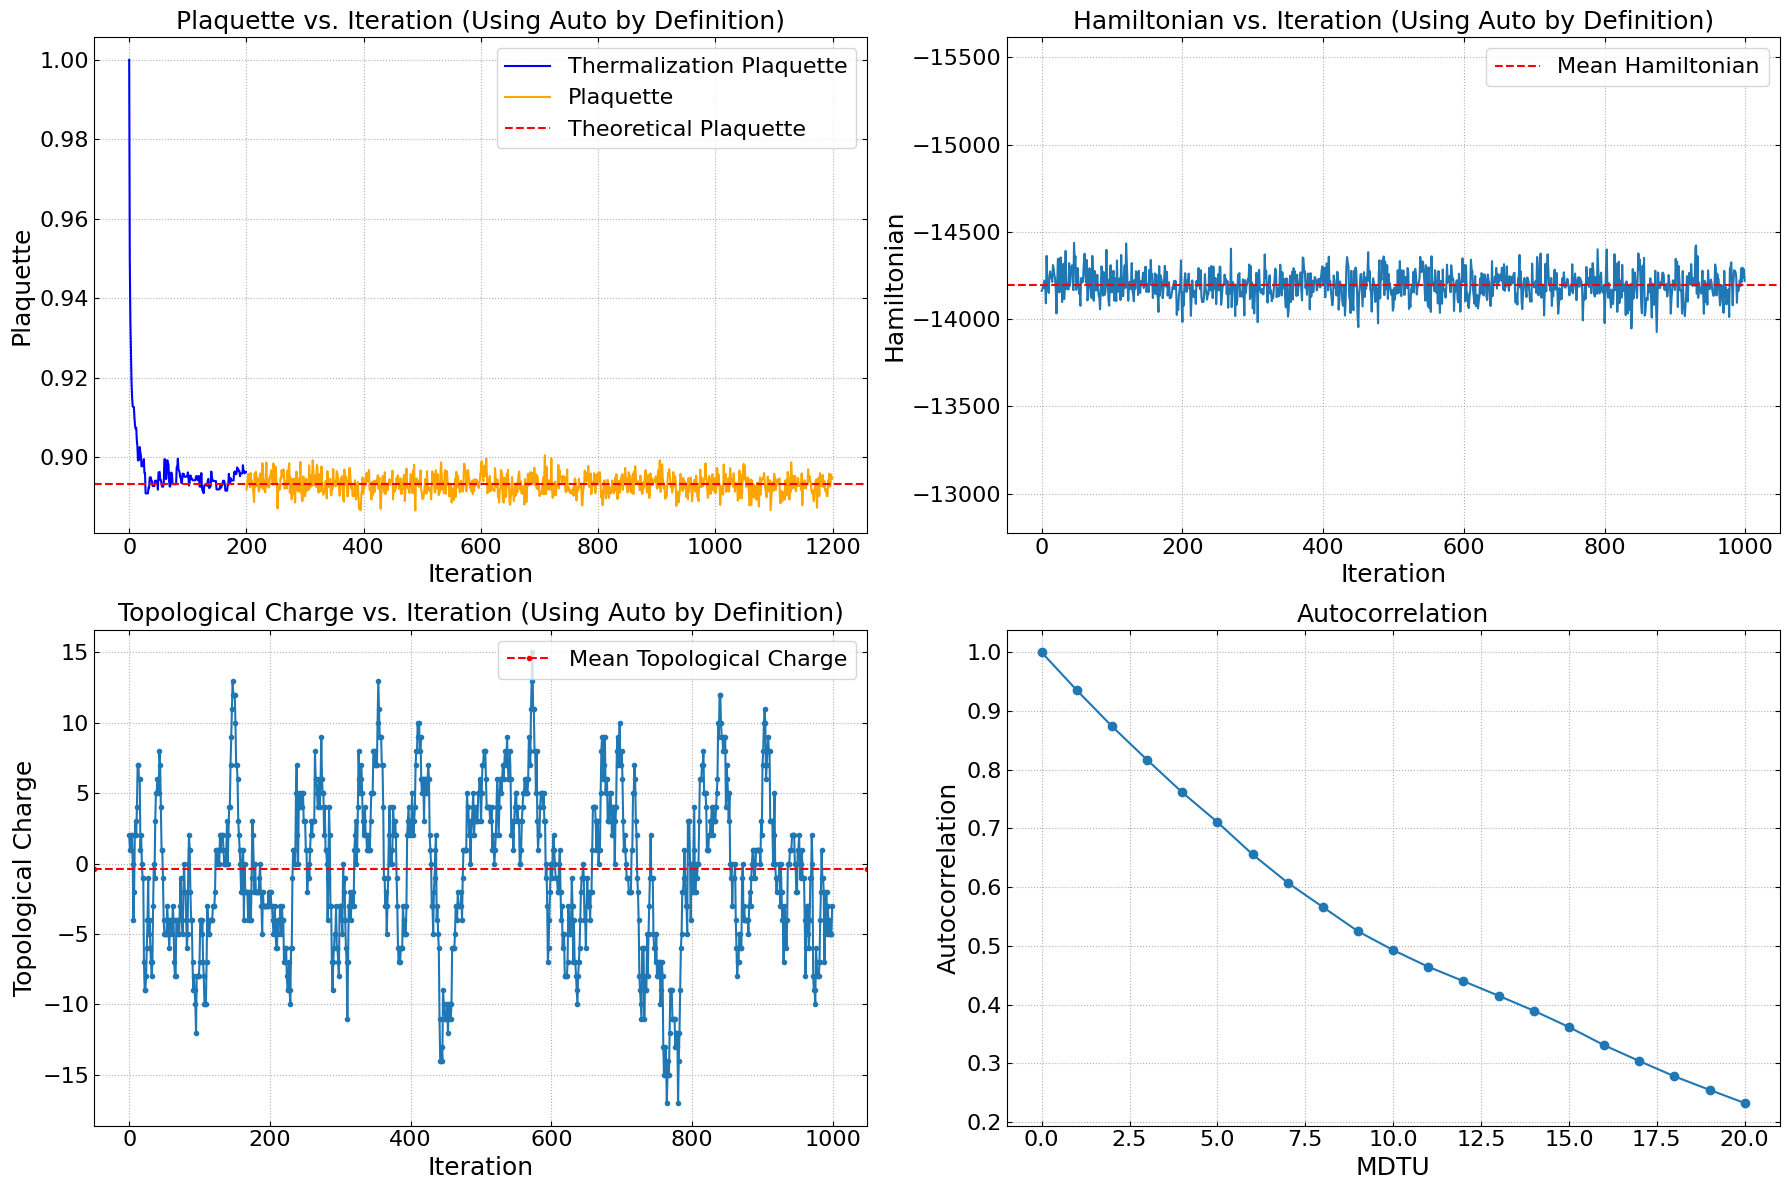

>>> Theoretical plaquette:  0.8933831370440852
>>> Mean plaq:  0.8931600286364555
>>> Std of mean plaq:  7.35442910107069e-05
Thermalization acceptance rate: 0.5800
Acceptance rate: 0.4903


In [3]:
print(">>> No Field Transformation HMC Simulation: ")

# Initialize HMC
hmc = HMC_U1(lattice_size, beta, n_thermalization_steps, n_steps, step_size, device=device)

# Thermalize the system
theta_thermalized, therm_plaq_ls, therm_acceptance_rate = hmc.thermalize()

# Run HMC without field transformation
config_ls, plaq_ls, acceptance_rate, topological_charges, hamiltonians = hmc.run(n_iterations, theta_thermalized, store_interval=10)

print(">>> Simulation completed")

# Compute autocorrelation of topological charges
max_lag = 20
hmc_summary(beta, max_lag, volume, therm_plaq_ls, plaq_ls, topological_charges, hamiltonians, therm_acceptance_rate, acceptance_rate)

In [4]:
# Perform RG evolution to get coarse-grained configurations
def rg_transform(config):
    """
    Perform RG transformation on a configuration by converting 2x2 blocks to single plaquettes.
    
    Parameters:
    -----------
    config : torch.Tensor
        Input configuration of shape (2, L, L)
        
    Returns:
    --------
    torch.Tensor
        Coarse-grained configuration of shape (2, L//2, L//2)
    """
    L = config.shape[1]
    new_L = L // 2
    
    # Initialize coarse-grained configuration
    coarse_config = torch.zeros((2, new_L, new_L), device=config.device)
    
    # For each 2x2 block
    for i in range(new_L):
        for j in range(new_L):
            # Extract the 2x2 block from original configuration
            block = config[:, 2*i:2*i+2, 2*j:2*j+2]
            
            # Two paths
            alpha = 0.5
            
            path_0_1 = block[0, 0, 0] + block[0, 1, 0]
            path_0_2 = block[1, 0, 0] + block[0, 0, 1] - block[1, 1, 0] + block[0, 1, 0]  
            
            theta_0 = torch.angle( alpha * torch.exp(1j * path_0_1) + (1 - alpha) * torch.exp(1j * path_0_2) )
            
            path_1_1 = block[1, 0, 0] + block[1, 0, 1]
            path_1_2 = block[0, 0, 0] + block[1, 1, 1] - block[0, 0, 1] + block[1, 0, 1]
            
            theta_1 = torch.angle( alpha * torch.exp(1j * path_1_1) + (1 - alpha) * torch.exp(1j * path_1_2) )
            
            # For horizontal links (direction 0)
            coarse_config[0, i, j] = regularize(theta_0)
            
            # For vertical links (direction 1) 
            coarse_config[1, i, j] = regularize(theta_1)
        
    return coarse_config

# Apply RG transformation to all configurations
coarse_config_ls = [rg_transform(config) for config in config_ls]

print(f"Number of configurations: {len(config_ls)}")
print(f"Original config shape: {config_ls[0].shape}")
print(f"Coarse-grained config shape: {coarse_config_ls[0].shape}")

# Save configurations to files
torch.save(config_ls, f'configs/2DU1_L{int(lattice_size)}.pt')
torch.save(coarse_config_ls, f'configs/2DU1_L{int(lattice_size / 2)}_RG.pt')
print(f"Saved configurations to configs/2DU1_L{int(lattice_size)}.pt and configs/2DU1_L{int(lattice_size / 2)}_RG.pt")




Number of configurations: 1000
Original config shape: torch.Size([2, 64, 64])
Coarse-grained config shape: torch.Size([2, 32, 32])
Saved configurations to configs/2DU1_L64.pt and configs/2DU1_L32_RG.pt


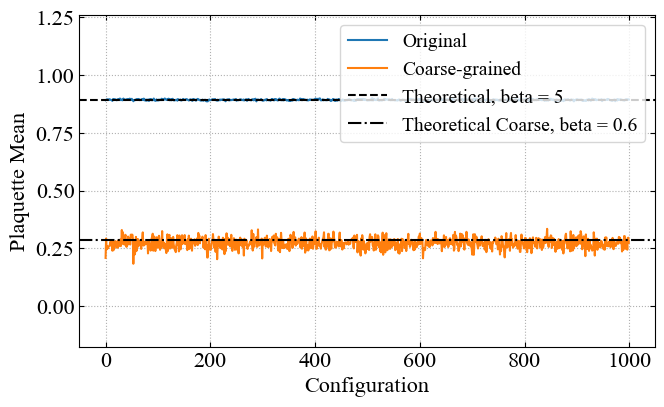

In [5]:
from utils import plaq_mean_from_field, plaq_mean_theory
from lametlat.utils.plot_settings import *

# Calculate plaquette means for coarse-grained configs
original_plaq_means = [plaq_mean_from_field(config).item() for config in config_ls]
coarse_plaq_means = [plaq_mean_from_field(config).item() for config in coarse_config_ls]

beta_coarse = 0.6

# Plot histogram of plaquette means
fig, ax = default_plot()
ax.plot(original_plaq_means, label='Original')
ax.plot(coarse_plaq_means, label='Coarse-grained')
# Calculate theoretical plaquette value
theoretical_plaq = plaq_mean_theory(beta)
theoretical_plaq_coarse = plaq_mean_theory(beta=beta_coarse)
ax.axhline(y=theoretical_plaq, color='black', linestyle='--', label=f'Theoretical, beta = {beta}')
ax.axhline(y=theoretical_plaq_coarse, color='black', linestyle='-.', label=f'Theoretical Coarse, beta = {beta_coarse}')
ax.set_xlabel('Configuration', **fs_p)
ax.set_ylabel('Plaquette Mean', **fs_p)
ax.grid(True)
ax.legend(loc="upper right", **fs_small_p)
ax.set_ylim(auto_ylim([original_plaq_means, coarse_plaq_means], [np.zeros_like(original_plaq_means), np.zeros_like(coarse_plaq_means)], y_range_ratio=2))
plt.tight_layout()
plt.savefig(f"plots/two_path_L{lattice_size}.pdf", transparent=True)
plt.show()


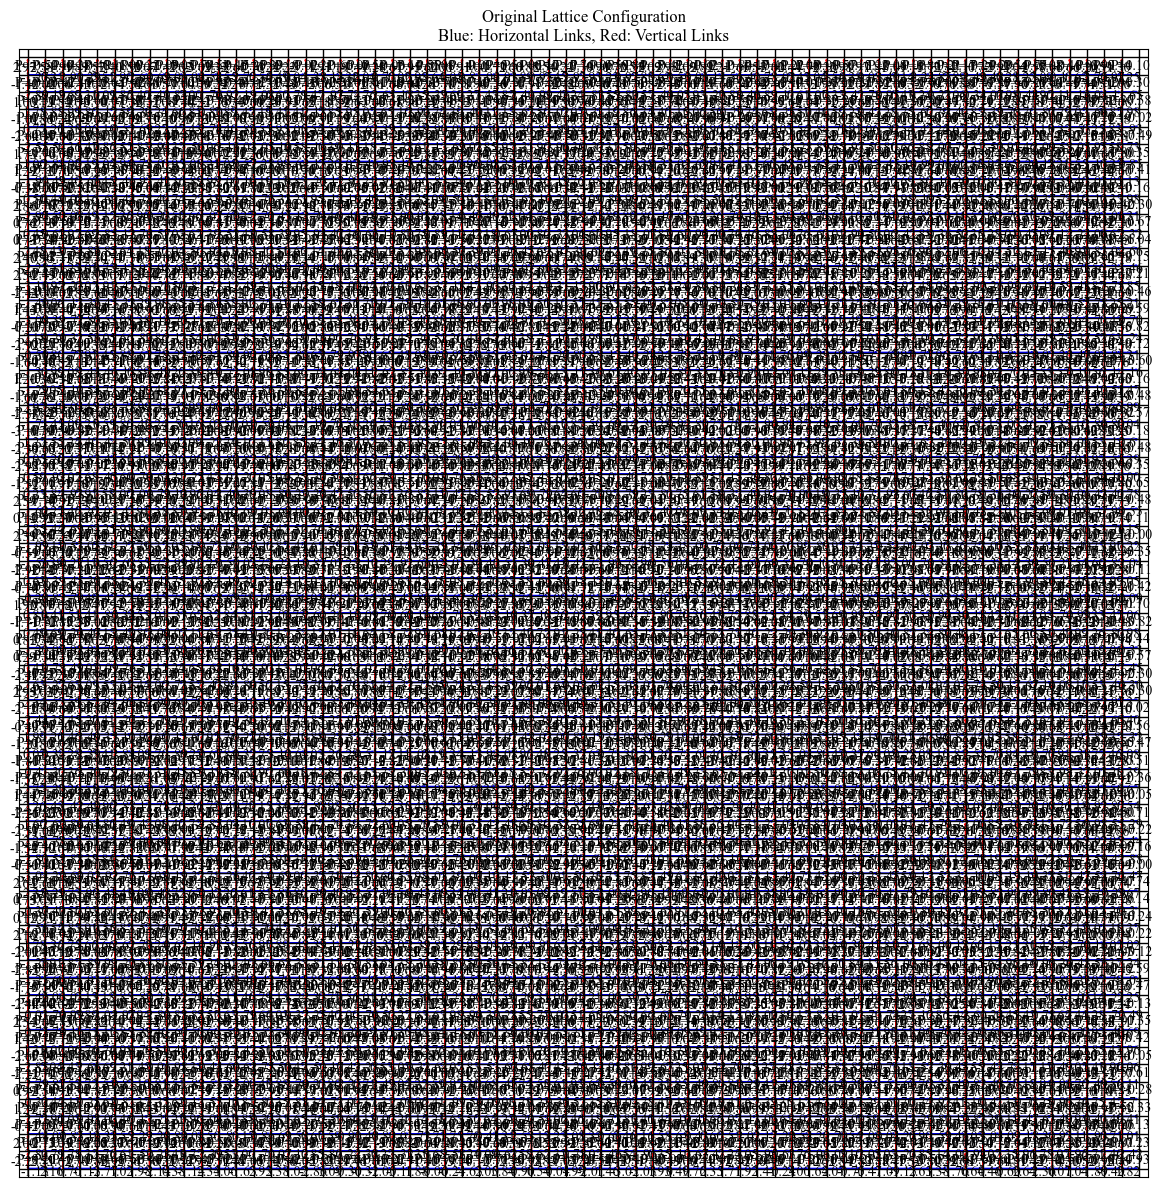

In [6]:
# Create a figure with a 2x2 grid visualization
fig, ax = plt.subplots(figsize=(12, 12))

# Get first configuration from original list
config = config_ls[0]
lattice_size = config.shape[1]  # Get lattice size from config shape

# Calculate plaquette values
thetaP = plaq_from_field(config)
thetaP_wrapped = regularize(thetaP)
# plaq_vals = torch.cos(thetaP_wrapped)
plaq_vals = thetaP_wrapped

# Plot grid lines
for i in range(lattice_size + 1):
    ax.axhline(y=i, color='black', linewidth=1)
    ax.axvline(x=i, color='black', linewidth=1)

# Plot horizontal links (direction 0) with values
for i in range(lattice_size):
    for j in range(lattice_size):
        # Get link value and format to 2 decimal places
        val = f"{config[0,i,j]:.2f}"
        # Plot arrow and text
        ax.arrow(i, j, 0.8, 0, head_width=0.1, head_length=0.1, fc='blue', ec='blue')
        ax.text(i+0.4, j-0.2, val, ha='center', va='center')

# Plot vertical links (direction 1) with values  
for i in range(lattice_size):
    for j in range(lattice_size):
        # Get link value and format to 2 decimal places
        val = f"{config[1,i,j]:.2f}"
        # Plot arrow and text
        ax.arrow(i, j, 0, 0.8, head_width=0.1, head_length=0.1, fc='red', ec='red')
        ax.text(i-0.2, j+0.4, val, ha='center', va='center')

# Add plaquette values in center of each square
for i in range(lattice_size):
    for j in range(lattice_size):
        plaq_val = f"{plaq_vals[i,j]:.2f}"
        ax.text(i+0.5, j+0.5, f"P={plaq_val}", ha='center', va='center')

ax.set_aspect('equal')
ax.set_xlim(-0.5, lattice_size + 0.5)
ax.set_ylim(-0.5, lattice_size + 0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Original Lattice Configuration\nBlue: Horizontal Links, Red: Vertical Links')
plt.tight_layout()
plt.show()


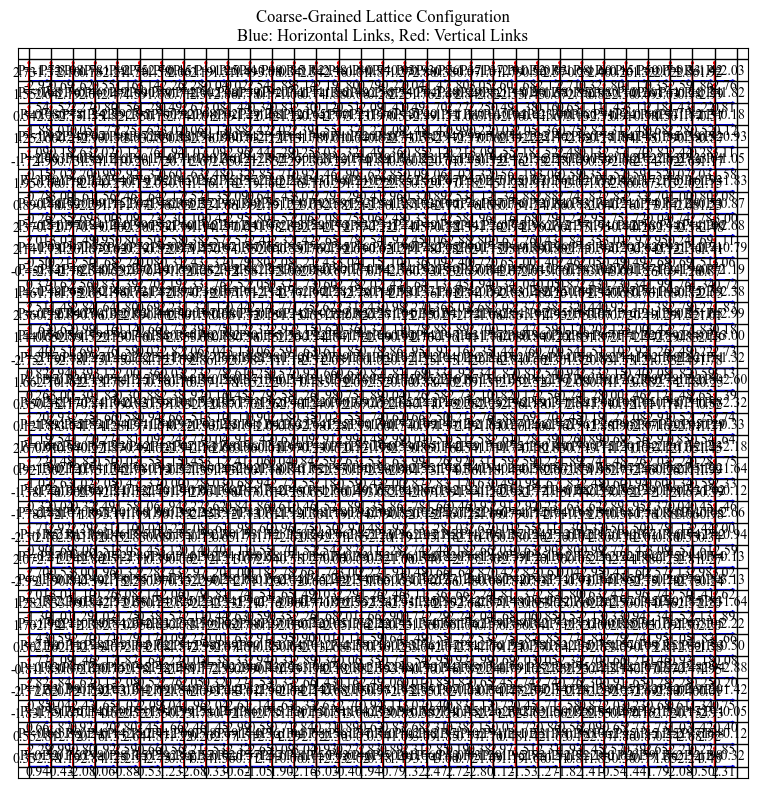

In [7]:
# Create a figure with a 2x2 grid visualization
fig, ax = plt.subplots(figsize=(8, 8))

# Get first configuration from coarse-grained list
config = coarse_config_ls[0]
lattice_size = config.shape[1]  # Get lattice size from config shape

# Calculate plaquette values
thetaP = plaq_from_field(config)
thetaP_wrapped = regularize(thetaP)
# plaq_vals = torch.cos(thetaP_wrapped)
plaq_vals = thetaP_wrapped

# Plot grid lines
for i in range(lattice_size + 1):
    ax.axhline(y=i, color='black', linewidth=1)
    ax.axvline(x=i, color='black', linewidth=1)

# Plot horizontal links (direction 0) with values
for i in range(lattice_size):
    for j in range(lattice_size):
        # Get link value and format to 2 decimal places
        val = f"{config[0,i,j]:.2f}"
        # Plot arrow and text
        ax.arrow(i, j, 0.8, 0, head_width=0.1, head_length=0.1, fc='blue', ec='blue')
        ax.text(i+0.4, j-0.2, val, ha='center', va='center')

# Plot vertical links (direction 1) with values  
for i in range(lattice_size):
    for j in range(lattice_size):
        # Get link value and format to 2 decimal places
        val = f"{config[1,i,j]:.2f}"
        # Plot arrow and text
        ax.arrow(i, j, 0, 0.8, head_width=0.1, head_length=0.1, fc='red', ec='red')
        ax.text(i-0.2, j+0.4, val, ha='center', va='center')

# Add plaquette values in center of each square
for i in range(lattice_size):
    for j in range(lattice_size):
        plaq_val = f"{plaq_vals[i,j]:.2f}"
        ax.text(i+0.5, j+0.5, f"P={plaq_val}", ha='center', va='center')

ax.set_aspect('equal')
ax.set_xlim(-0.5, lattice_size + 0.5)
ax.set_ylim(-0.5, lattice_size + 0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Coarse-Grained Lattice Configuration\nBlue: Horizontal Links, Red: Vertical Links')
plt.tight_layout()
plt.show()
